<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>03 - Bert Baseline Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook the *Bert Baseline Model* proposed for the *Identifying the Human Values behind Arguments* task is built and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

## Download of the Dataset

In [3]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
TARGETS = labels_train_df.columns.to_list()

In [5]:
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
    split_dataframes(arguments_train_df, labels_train_df, seed=SEED)

# Model and Tokenizer Definition

In [6]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'bert-base-uncased'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, problem_type='multi_label_classification')

# Add the tokens encoding the stance to the tokenizer.
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

# Build a dictionary to encde the stance.
stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [8]:
from src.models.transformer_model import get_transformer_model

model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)

In [9]:
print('Model structure:')
print(model)

Model structure:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Training

### Create Dataloaders

In [10]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                             stance_encoder, is_transformer=True, 
                             batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                             use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                             stance_encoder, is_transformer=True,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                             stance_encoder, is_transformer=True,
                             batch_size=BATCH_SIZE_EVAL, shuffle=False,
                             use_augmentation=False)

### Training parameters

In [11]:
import os
from torch.optim import Adam
from torch.nn.modules import BCEWithLogitsLoss
from src.training.training_utils import Checkpoint, EarlyStopping

# Set the number of epochs.
EPOCHS = 20
# Set the learning rate.
LEARNING_RATE = 2e-05
# Set how many training steps to use for validation.
STEPS_VALIDATE = 200

# Set the loss function.
loss_function = BCEWithLogitsLoss()

# Set the the optimizer.
optimizer = Adam(params=model.parameters(), lr=LEARNING_RATE)

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models',
                                                 'bert_baseline.pth'))
early_stopping = EarlyStopping()

### Training

In [12]:
from src.training.training import train

# Train the model.
train_loss_history, val_loss_history, val_f1_macro_history = train(
    train_loader, val_loader, model, optimizer, loss_function, DEVICE, 
    epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
    early_stopping=early_stopping, reload_best_weights=True,
    use_threshold_selection=False)

epoch: 1/20, 199/540, 34s 171ms/step, loss: 0.454                
validate: 5s, validation loss: 0.407, validation f1 macro: 1.17 %                
epoch: 1/20, 399/540, 65s 164ms/step, loss: 0.427                
validate: 5s, validation loss: 0.379, validation f1 macro: 7.68 %                
epoch: 1/20, 540/540, 88s 164ms/step, loss: 0.417                
---------------------------------------------------------------
epoch: 1/20, 88s, loss: 0.417, val loss:, 0.369, val f1 macro: 11.1 %
epoch: 2/20, 199/540, 26s 131ms/step, loss: 0.366                
validate: 5s, validation loss: 0.352, validation f1 macro: 20.4 %                
epoch: 2/20, 399/540, 69s 172ms/step, loss: 0.359                
validate: 5s, validation loss: 0.341, validation f1 macro: 22.8 %                
epoch: 2/20, 540/540, 92s 171ms/step, loss: 0.358                
---------------------------------------------------------------
epoch: 2/20, 92s, loss: 0.358, val loss:, 0.342, val f1 macro: 23.3 %
epoch: 3

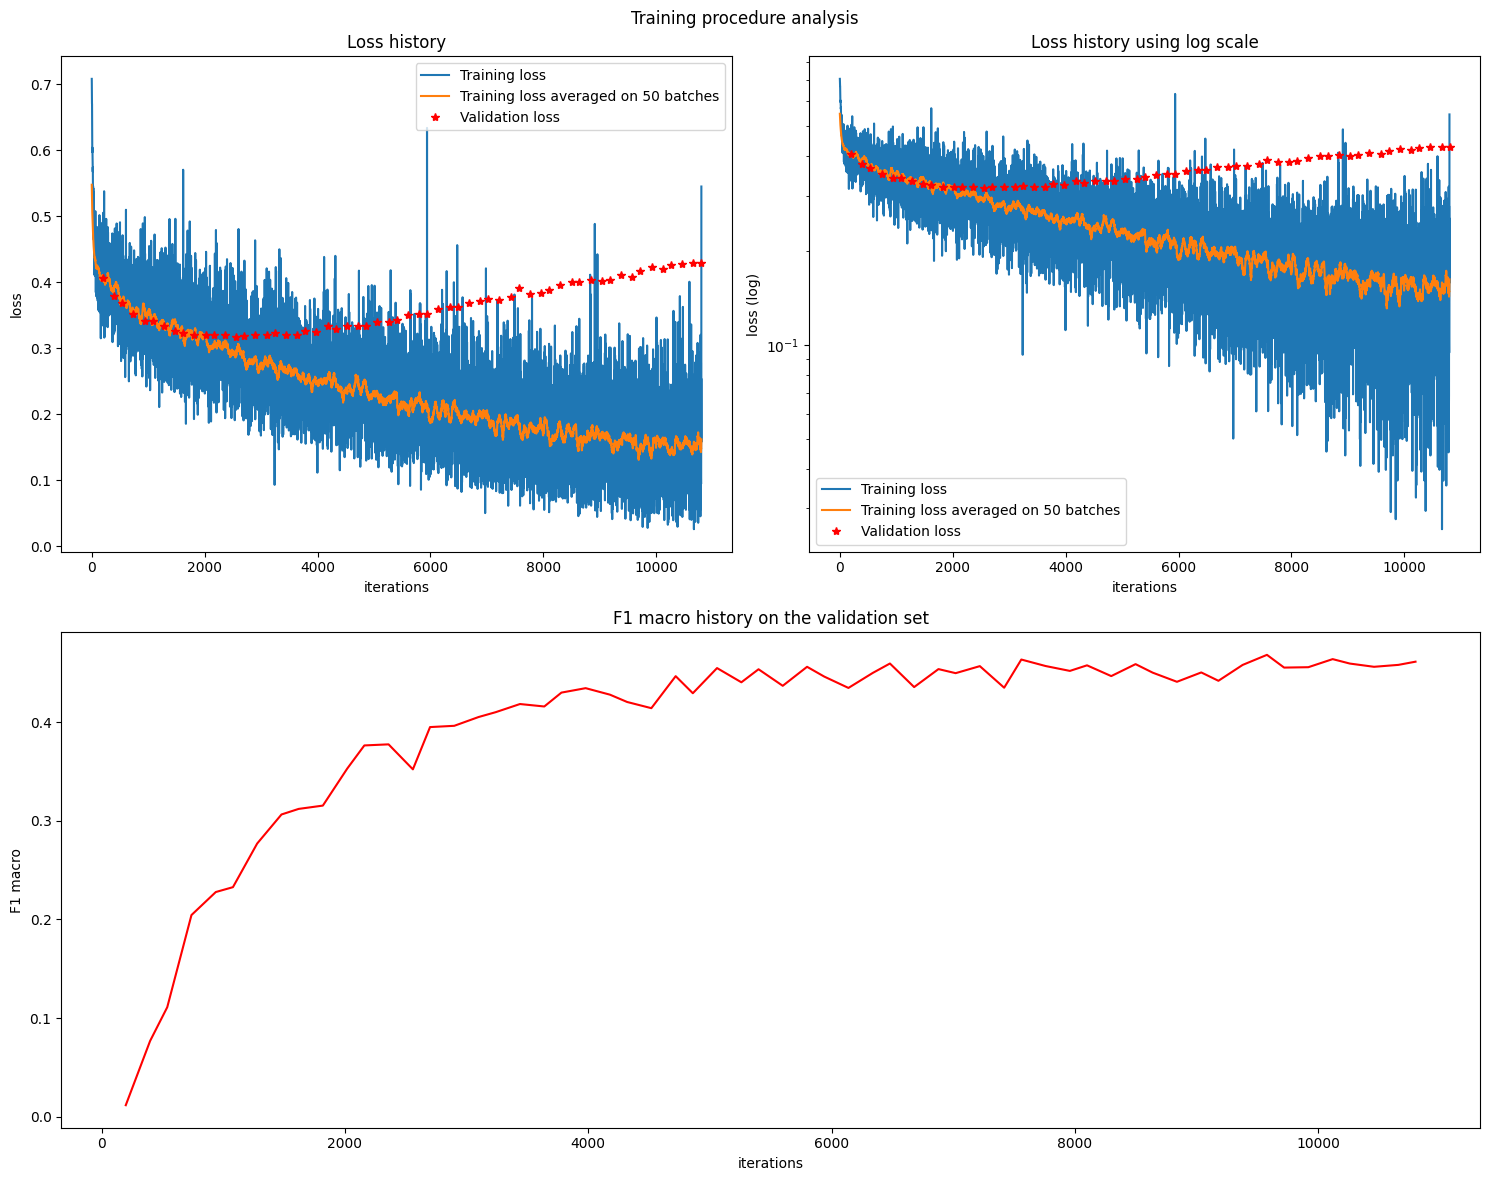

In [13]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

# Model Evaluation

## Evaluation on the Validation set

In [14]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.461


In [15]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.61      0.63      0.62       184
    Self-direction: action       0.57      0.66      0.61       261
               Stimulation       0.33      0.06      0.10        51
                  Hedonism       0.50      0.09      0.15        35
               Achievement       0.63      0.58      0.60       300
          Power: dominance       0.43      0.38      0.40       128
          Power: resources       0.61      0.48      0.54       129
                      Face       0.45      0.13      0.20        78
        Security: personal       0.70      0.71      0.71       406
        Security: societal       0.70      0.71      0.70       345
                 Tradition       0.68      0.39      0.49       114
         Conformity: rules       0.53      0.47      0.50       249
 Conformity: interpersonal       0.57      0.23      0.33        35
 

## Evaluation on the Test set

In [16]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.388


In [17]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.48      0.46      0.47       251
    Self-direction: action       0.48      0.57      0.52       496
               Stimulation       0.50      0.07      0.13       138
                  Hedonism       0.61      0.11      0.18       103
               Achievement       0.67      0.56      0.61       575
          Power: dominance       0.32      0.24      0.27       164
          Power: resources       0.44      0.36      0.40       132
                      Face       0.45      0.07      0.12       130
        Security: personal       0.68      0.76      0.72       759
        Security: societal       0.61      0.63      0.62       488
                 Tradition       0.64      0.27      0.38       172
         Conformity: rules       0.54      0.41      0.47       455
 Conformity: interpersonal       0.46      0.10      0.16        60
       